In [2]:

# Example notebook to parse and plot Summit CPC data.
# By Heather Guy, 2019-11-20

# Import useful packages.

import matplotlib
#matplotlib.use('Agg')
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as md
import pandas as pd
from matplotlib import rcParams
import matplotlib.colors as colors
import os
import glob
from scipy import io

import sys
sys.path.append('/Users/heather/ICECAPS-ACE/DataParse/')

from ace_parse import *
from utils import * 


In [3]:
# Function to parse CPC data

def get_cpc(start,stop,d_loc):
    f_date_list = pd.date_range(start.date(),stop.date(),freq='1D')
    CPC_out = pd.DataFrame(columns=['c/cm3', 'QC'])
    for date in f_date_list:
        f = d_loc + r'CPC_%s'%(str(date.date()))
        
        try:
            data = pd.read_csv(f,parse_dates=[0],index_col=[0])
        except:
            print('No data for %s'%str(date.date()))
            continue

        CPC_out = CPC_out.append(data,sort=True)    
    
    # Get rid of any duplicates
    CPC_out = CPC_out[~CPC_out.index.duplicated()]
    
    # Fill any missing minutes with nans
    new_index = pd.date_range(CPC_out.index[0],CPC_out.index[-1] , freq='min')
    CPC_out = CPC_out.reindex(new_index)
    
    # Crop to datetime
    CPC_out=CPC_out[start:stop]
    
    return CPC_out
    

In [39]:
# Get the data

d_loc = '/Volumes/Data/ICECAPSarchive/ace/processed/CPC/'
d1 = dt.datetime(2019,2,15,0,0)
d2 = dt.datetime(2019,12,30,23,59)

cpc = get_cpc(d1,d2,d_loc)
cpc_qc = cpc.copy()
cpc_qc['c/cm3'][cpc['QC']!=1]=np.nan

No data for 2019-05-11
No data for 2019-08-15
No data for 2019-08-17


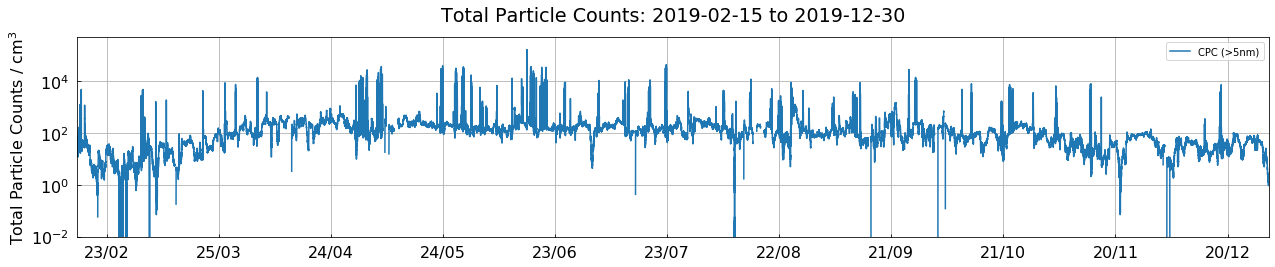

In [40]:
# Plot total counts No QC

fig = plt.figure(figsize=(18,4))
ax = fig.add_subplot(111)
ax.grid(True)
ax.semilogy(cpc.index,cpc['c/cm3'], label='CPC (>5nm)')   
ax.set_ylim(0.01,500000)
ax.set_ylabel('Total Particle Counts / cm$^3$')
ax.set_title('Total Particle Counts: %s'%((dt.datetime.strftime(d1,'%Y-%m-%d')+' to '+dt.datetime.strftime(d2,'%Y-%m-%d'))))
ax.xaxis.set_major_formatter(md.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(md.DayLocator(interval=30))
ax.set_xlim(d1,d2)
ax.legend(loc='best',fontsize=10)
fig.tight_layout()
#fig.savefig(d_loc + 'Ncounts_current.png')


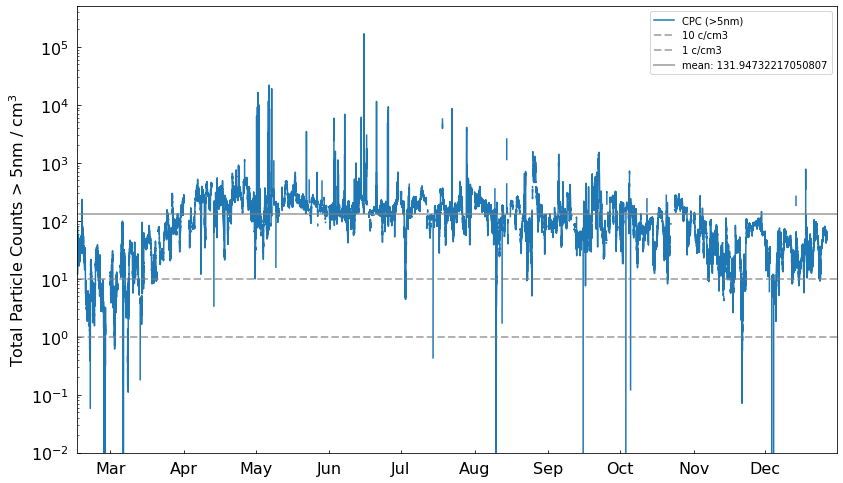

In [41]:
# Plot total counts with QC

from matplotlib import rcParams
# Plotting preferences:
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams.update({'font.size': 16}) 
rcParams['axes.titlepad'] = 16 
rcParams['xtick.major.pad']='8'
rcParams['ytick.major.pad']='8'

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)
#ax.grid(True)
ax.semilogy(cpc_qc.index,cpc_qc['c/cm3'], label='CPC (>5nm)')   
ax.set_ylim(0.01,500000)
ax.set_ylabel('Total Particle Counts > 5nm / cm$^3$')
#ax.set_title('QCd Total Particle Counts: %s'%((dt.datetime.strftime(d1,'%Y-%m-%d')+' to '+dt.datetime.strftime(d2,'%Y-%m-%d'))))

ax.xaxis.set_major_formatter(md.DateFormatter('%b'))
ax.xaxis.set_major_locator(md.DayLocator(bymonthday=1))

# Plot low aerosol line
ax.axhline(10,c='grey',ls='--',lw=2,alpha=0.6,label='10 c/cm3')
ax.axhline(1,c='grey',ls='--',lw=2,alpha=0.6,label='1 c/cm3')
ax.axhline(np.mean(cpc_qc['c/cm3']),c='grey',ls='-',lw=2,alpha=0.6,label='mean: %s'%np.mean(cpc_qc['c/cm3']))

ax.set_xlim(d1,d2)
ax.legend(loc='best',fontsize=10)
fig.tight_layout()
#fig.savefig(d_loc + 'Ncounts_current.png')

In [48]:
# percent of time below 10 c/cm3
(len(cpc_qc[cpc_qc['c/cm3']<10]) / len(cpc_qc['c/cm3'])) * 100

5.431905259491467

In [26]:
# Aerosol counts frequency plot (histogram)

nbins = 1000
bins = np.logspace(0.001,4,nbins)
#widths = np.linspace(1,4,nbins-1)
hist = np.histogram(cpc_qc['c/cm3'], bins=bins)[0]



In [17]:
mode = bins[np.where(hist == max(hist))[0][0]]
mean = np.mean(cpc_qc['c/cm3'])

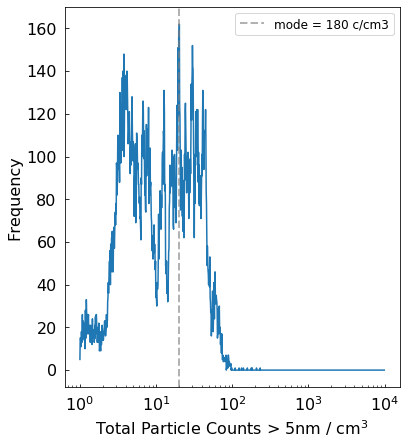

In [18]:
fig = plt.figure(figsize=(6,7))
ax1 = fig.add_subplot(111)
#ax1.grid(True)


#ax1.bar(bins[:-1],hist,width=widths,align='edge')
ax1.plot(bins[:-1],hist)
ax1.axvline(mode,c='grey',ls='--',lw=2,alpha=0.6,label='mode = 180 c/cm3')
ax1.set_xscale('log')

ax1.set_ylabel('Frequency')
ax1.set_xlabel('Total Particle Counts > 5nm / cm$^3$')

#ax.set_title('Total Particle Counts: %s'%((dt.datetime.strftime(d1,'%Y-%m-%d')+' to '+dt.datetime.strftime(d2,'%Y-%m-%d'))))
#ax.xaxis.set_major_formatter(md.DateFormatter('%d/%m'))
#ax.xaxis.set_major_locator(md.DayLocator(interval=30))
#ax.set_xlim(d1,d2)
ax1.legend(loc='best',fontsize=12)
#plt.bar(bins[:-1],hist,align='edge')

In [79]:
# Print day times where CPC counts go < 0.1
# Dates when concentrations less than.... 
lim = 1
time_lim = 1 # hours


low_count_dates = cpc_qc[cpc_qc['c/cm3']<lim].index

In [80]:
starts = []
stops = []
starts.append(low_count_dates[0])
a = low_count_dates[0]

for i in range(1,len(low_count_dates)):
    if low_count_dates[i] - a > pd.Timedelta(hours=time_lim):
        stops.append(low_count_dates[i-1])
        starts.append(low_count_dates[i])
        
    a = low_count_dates[i]
    
stops.append(low_count_dates[-1])


# Make sure the events last at least 10 mins
long_starts=[]
long_stops=[]
for i in range(0,len(starts)):
    if stops[i] - starts[i] > pd.Timedelta(hours=time_lim):
        long_starts.append(starts[i])
        long_stops.append(stops[i])
        

In [83]:
len(long_starts)

9

In [84]:
len(long_stops)

9